In [62]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam


# Load Data

In [78]:
import os
import numpy as np


def load_data(folder):
    data = []
    labels = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file)
                if file.endswith('.npy'):
                    # Load numpy array
                    array = np.load(file_path).flatten()
                    data.append(array)
                    # Label phishing as 1, benign as 0
                    label = 1 if (folder.find('phishing') != -1) else 0
                    labels.append(label)
    return np.array(data), np.array(labels)

# Đường dẫn đến thư mục chứa dữ liệu
phishing_path = 'VisualPhish/phishing_features'
benign_path = 'VisualPhish/trusted_list_features'

# Load dữ liệu
phishing_data, phishing_labels = load_data(phishing_path)
benign_data, benign_labels = load_data(benign_path)



# DCGAN

In [64]:
def build_generator(z_dim):
    model = Sequential()

    # Bắt đầu từ vector nhiễu
    model.add(Dense(256 * 8 * 8, input_dim=z_dim))
    model.add(Reshape((8, 8, 256)))

    # Mở rộng kích thước bằng Conv2DTranspose
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    # Làm phẳng để tạo vector 512 chiều
    model.add(Flatten())
    model.add(Dense(512))

    return model


In [65]:
def build_discriminator(img_shape=(512,)):
    model = Sequential()

    model.add(Dense(8 * 8 * 256, input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Reshape((8, 8, 256)))

    # Thêm các lớp Conv2D
    model.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model


In [66]:
def build_dcgan(generator, discriminator):
    model = Sequential()

    model.add(generator)
    model.add(discriminator)

    return model

z_dim = 100
batch_size = 32

discriminator = build_discriminator((512,))
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

generator = build_generator(z_dim)

discriminator.trainable = False
dcgan = build_dcgan(generator, discriminator)
dcgan.compile(loss='binary_crossentropy', optimizer=Adam())


In [67]:
def train_dcgan(dcgan, generator, discriminator, dataset, z_dim, epochs=100):
    for epoch in range(epochs):
        for real_images in dataset:
            # Điều chỉnh kích thước của z dựa trên kích thước thực tế của real_images
            current_batch_size = real_images.shape[0]
            z = np.random.normal(0, 1, (current_batch_size, z_dim))
            fake_images = generator.predict(z, verbose=0)

            combined_images = np.concatenate([real_images, fake_images])
            labels = np.concatenate([np.ones((current_batch_size, 1)), np.zeros((current_batch_size, 1))])
            labels += 0.05 * np.random.random(labels.shape)

            d_loss = discriminator.train_on_batch(combined_images, labels)

            z = np.random.normal(0, 1, (current_batch_size, z_dim))
            fake_labels = np.ones((current_batch_size, 1))

            g_loss = dcgan.train_on_batch(z, fake_labels)

        print(f"Epoch: {epoch + 1}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

# Chia dataset thành các batch
dataset = [phishing_data[i:i + batch_size] for i in range(0, len(phishing_data), batch_size)]
if len(dataset[-1]) != batch_size:
    dataset.pop()  # Xóa batch cuối nếu kích thước không phù hợp

# Khởi tạo và huấn luyện mô hình DCGAN
#train_dcgan(dcgan, generator, discriminator, dataset, z_dim, 100)


# Tái tạo kiến trúc mô hình
generator = build_generator(z_dim)
discriminator = build_discriminator((512,))

# Tải trọng số
generator.load_weights('generator_weights.h5')
discriminator.load_weights('discriminator_weights.h5')
"""

generator.save_weights('generator_weights.h5')
discriminator.save_weights('discriminator_weights.h5')
"""


"\n\ngenerator.save_weights('generator_weights.h5')\ndiscriminator.save_weights('discriminator_weights.h5')\n"

In [68]:
import matplotlib.pyplot as plt
import numpy as np

def showFeature(features):
  image = features.reshape(16, 32)
  #print(image.shape)
  #print(image)
  
  plt.subplot(1, 1, 1)  # Tạo subplot
  plt.imshow(image, cmap='viridis')  # Sử dụng viridis làm bảng màu
  plt.title(f'Feature map')
  plt.axis('off')  # Ẩn trục tọa độ

  plt.show()

================ 0 =================
Fake:


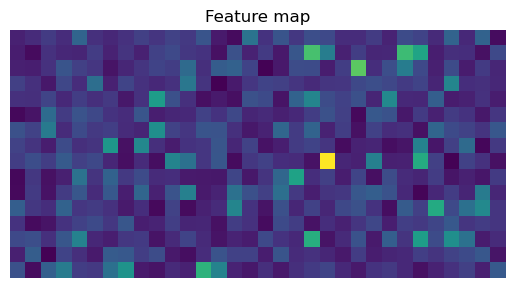

Real:


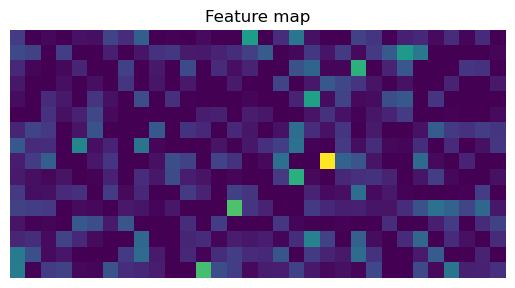

================ 1 =================
Fake:


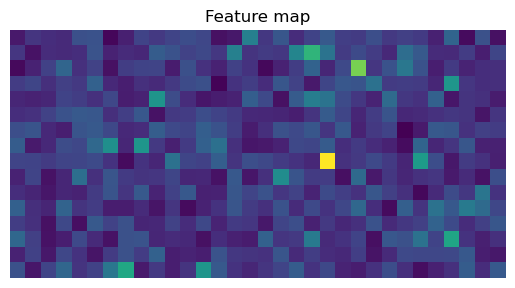

Real:


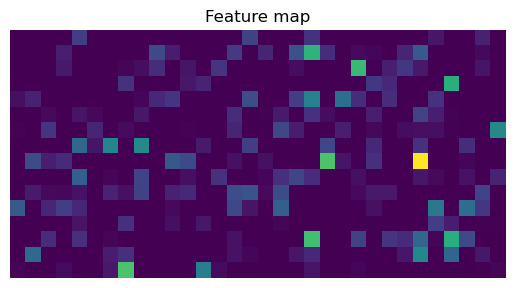

================ 2 =================
Fake:


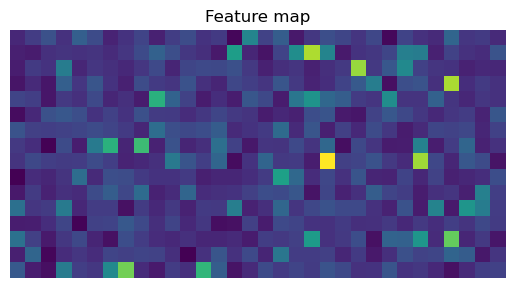

Real:


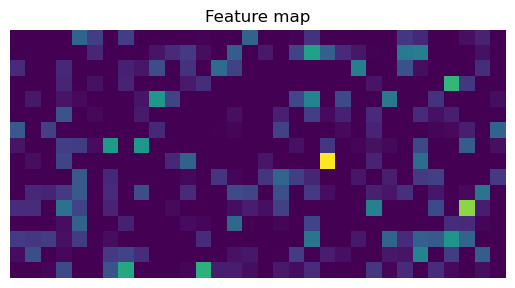

================ 3 =================
Fake:


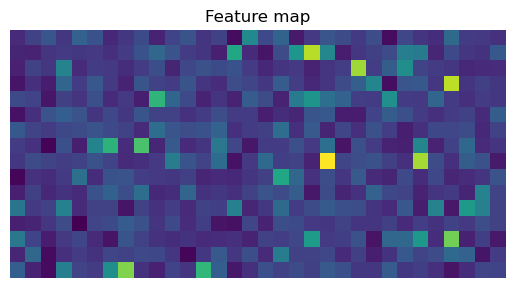

Real:


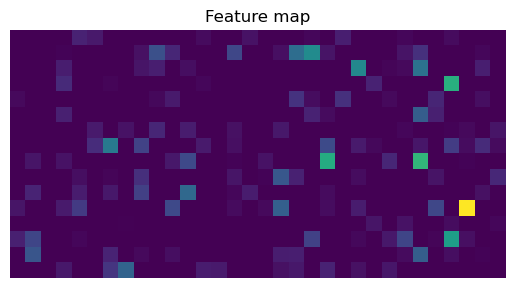

================ 4 =================
Fake:


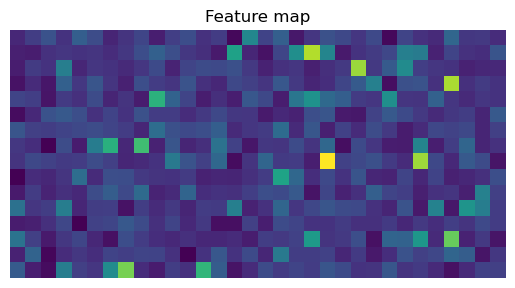

Real:


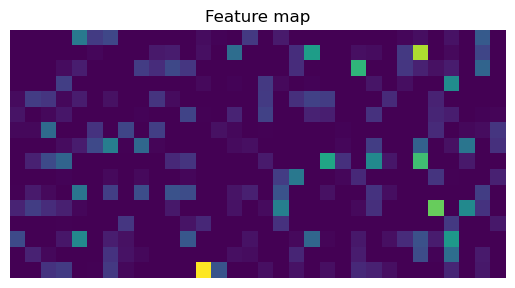

================ 5 =================
Fake:


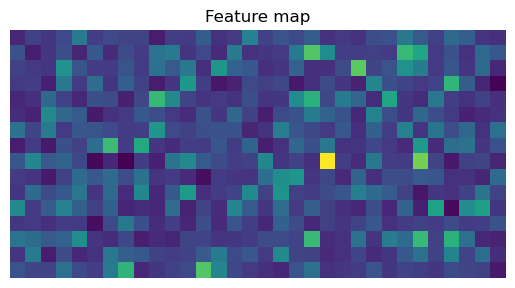

Real:


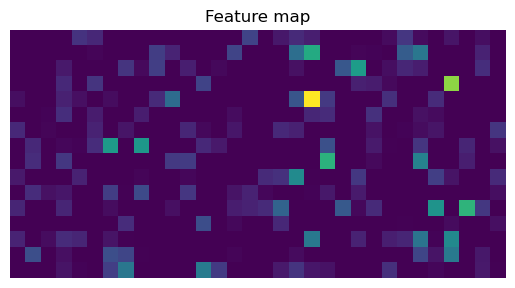

================ 6 =================
Fake:


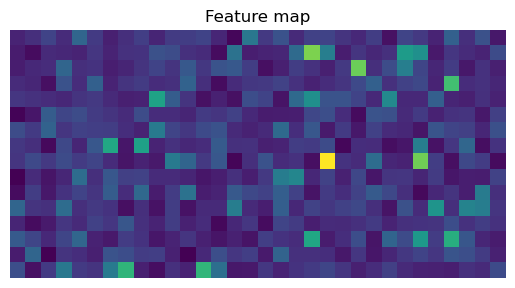

Real:


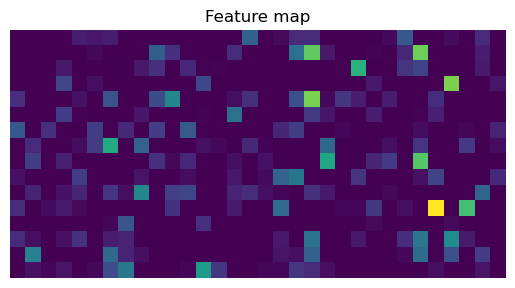

================ 7 =================
Fake:


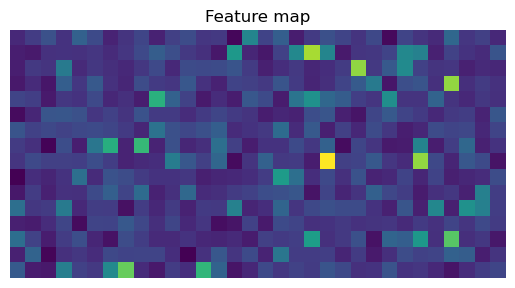

Real:


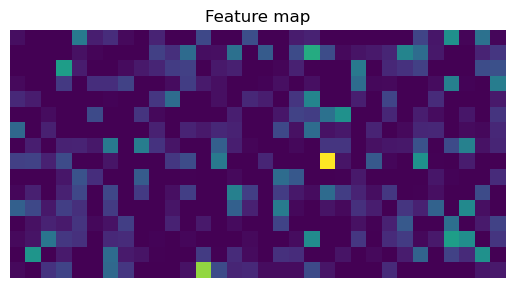

================ 8 =================
Fake:


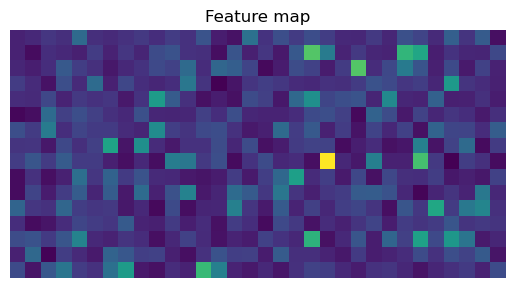

Real:


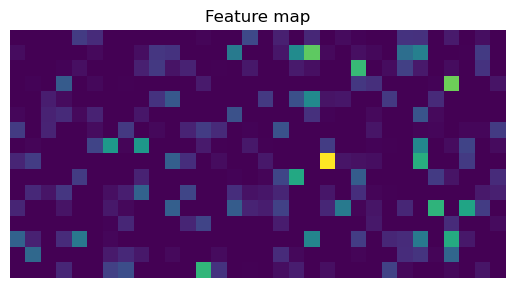

================ 9 =================
Fake:


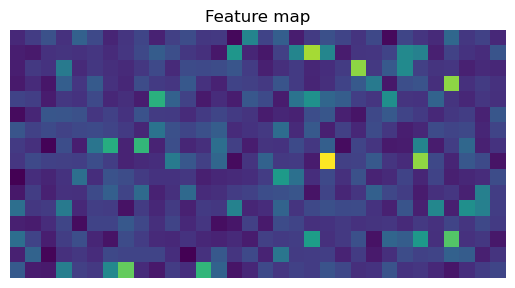

Real:


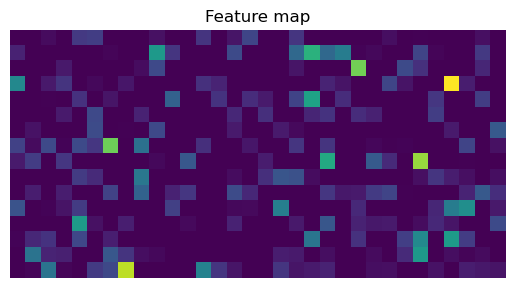

In [69]:
z = np.random.normal(0, 1, (10, z_dim))
fake_images = generator.predict(z, verbose=0)
for i in range(10):
  print("================", i, "=================")
  print("Fake:")
  showFeature(fake_images[i])
  print("Real:")
  showFeature(dataset[0][i])

In [ ]:
"""
@tf.function
def train_step(images, z_dim, discriminator, generator, discriminator_optimizer, generator_optimizer):
    # Tạo nhiễu ngẫu nhiên
    noise = tf.random.normal([batch_size, z_dim])

    # GradientTape cho discriminator
    with tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # GradientTape cho generator
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    """


In [79]:
print(benign_data.shape)
print(phishing_data.shape)

(9363, 512)
(1195, 512)


In [80]:
while (len(phishing_data) < len(benign_data)):
  print(len(phishing_data), "/", len(benign_data))
  z = np.random.normal(0, 1, (1, z_dim))
  gen_img = generator.predict(z, verbose=0)

  phishing_data = np.vstack((phishing_data, gen_img[0]))
  phishing_labels = np.append(phishing_labels, 1)

print(phishing_data.shape)
print(benign_data.shape)
# Gộp dữ liệu và labels
X = np.concatenate((phishing_data, benign_data), axis=0)
y = np.concatenate((phishing_labels, benign_labels), axis=0)

1195 / 9363
1196 / 9363
1197 / 9363
1198 / 9363
1199 / 9363
1200 / 9363
1201 / 9363
1202 / 9363
1203 / 9363
1204 / 9363
1205 / 9363
1206 / 9363
1207 / 9363
1208 / 9363
1209 / 9363
1210 / 9363
1211 / 9363
1212 / 9363
1213 / 9363
1214 / 9363
1215 / 9363
1216 / 9363
1217 / 9363
1218 / 9363
1219 / 9363
1220 / 9363
1221 / 9363
1222 / 9363
1223 / 9363
1224 / 9363
1225 / 9363
1226 / 9363
1227 / 9363
1228 / 9363
1229 / 9363
1230 / 9363
1231 / 9363
1232 / 9363
1233 / 9363
1234 / 9363
1235 / 9363
1236 / 9363
1237 / 9363
1238 / 9363
1239 / 9363
1240 / 9363
1241 / 9363
1242 / 9363
1243 / 9363
1244 / 9363
1245 / 9363
1246 / 9363
1247 / 9363
1248 / 9363
1249 / 9363
1250 / 9363
1251 / 9363
1252 / 9363
1253 / 9363
1254 / 9363
1255 / 9363
1256 / 9363
1257 / 9363
1258 / 9363
1259 / 9363
1260 / 9363
1261 / 9363
1262 / 9363
1263 / 9363
1264 / 9363
1265 / 9363
1266 / 9363
1267 / 9363
1268 / 9363
1269 / 9363
1270 / 9363
1271 / 9363
1272 / 9363
1273 / 9363
1274 / 9363
1275 / 9363
1276 / 9363
1277 / 9363
1278

# DNN

In [81]:

model = Sequential([
    Dense(1024, activation='relu', input_shape=(512,)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [82]:
from sklearn.model_selection import train_test_split

# Phân chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
469/469 [==============================] - 9s 16ms/step - loss: 0.2984 - accuracy: 0.9225
Epoch 2/10
469/469 [==============================] - 8s 17ms/step - loss: 0.1968 - accuracy: 0.9349
Epoch 3/10
469/469 [==============================] - 7s 16ms/step - loss: 0.1722 - accuracy: 0.9383
Epoch 4/10
469/469 [==============================] - 8s 16ms/step - loss: 0.1325 - accuracy: 0.9503
Epoch 5/10
469/469 [==============================] - 7s 16ms/step - loss: 0.1104 - accuracy: 0.9573
Epoch 6/10
469/469 [==============================] - 8s 16ms/step - loss: 0.1326 - accuracy: 0.9549
Epoch 7/10
469/469 [==============================] - 8s 17ms/step - loss: 0.1109 - accuracy: 0.9578
Epoch 8/10
469/469 [==============================] - 8s 16ms/step - loss: 0.0782 - accuracy: 0.9705
Epoch 9/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0822 - accuracy: 0.9702
Epoch 10/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0786 - accura

In [83]:
# Đánh giá hiệu suất
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy*100:.2f}%")


118/118 [==============================] - 1s 4ms/step - loss: 0.1632 - accuracy: 0.9552
Accuracy: 95.52%


In [84]:
print(len(X_train))
print(len(X_test))

14980
3746


In [85]:
cnt1Train = 0
cnt0Train = 0
for y in y_train:
  if y == 1:
    cnt1Train+=1
  else:
    cnt0Train+=1

print(cnt1Train)
print(cnt1Train / len(y_train))
print(cnt0Train)
print(cnt0Train / len(y_train))


7488
0.4998664886515354
7492
0.5001335113484646


In [86]:
cnt1Test = 0
cnt0Test = 0
for y in y_test:
  if y == 1:
    cnt1Test+=1
  else:
    cnt0Test+=1

print(cnt1Test)
print(cnt1Test / len(y_test))
print(cnt0Test)
print(cnt0Test / len(y_test))


1875
0.500533902829685
1871
0.499466097170315


In [87]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)
y_pred = [1 if y > 0.5 else 0 for y in y_pred]  # Chuyển đổi xác suất thành nhãn dự đoán

# Tính toán các chỉ số đánh giá
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC: {auc:.2f}")


118/118 [==============================] - 1s 5ms/step
Precision: 0.98
Recall: 0.93
F1-Score: 0.95
AUC: 0.96
